TODO
- Integrate Cale's aWhere grid script
- Add new AoI: Siskiyou
- auto-calculate day range for binary threshold
- "start_date" and "end_date" need to be auto-formatted in main loop
- change colors of final map
- merge branch into master
- **overlay other data**
- find Moran's i for binary_grid
- delete/move testing cells
- comment functions

In [1]:
import os
from pathlib import Path
import calendar
import datetime
from datetime import date

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon

import requests as rq

# for aWhere API
from header import AWhereAPI
from secret_codes import *

api_key = API_KEY
api_secret = API_SECRET

In [2]:
# Create aWhere object
aw = AWhereAPI(api_key, api_secret)

# To get auth token, encode secret and key
sc = aw.encode_secret_and_key(API_KEY, API_SECRET)

# Then call auth token
token = aw.get_oauth_token(sc)

In [3]:
# Set variables for aWhere API call 

# General endpoint
endpt = "https://api.awhere.com"

# Set up headers: auth and specific header for agronomics data
auth_headers = {"Authorization": "Bearer %s" % token,
                "Content-Type": 'application/json'}

agro_header = {"Authorization":  "Bearer %s" % token}

In [4]:
# Load areas of interest into gpd
# Siskiyou is area of interest, Josephine is for testing API

# Create path to home
home = str(Path.home())

# Create paths to geojsons since csvs make Jupyter crash
path_to_josephine = os.path.join(
    home, "Desktop", "drought-tracker", "data", "TIGER", "josephine.geojson")

path_to_siskiyou = os.path.join(
    home, "Desktop", "drought-tracker", "data", "TIGER", "siskiyou.geojson")

# Create dfs with 1 county (Josephine is for testing)
josephine = gpd.read_file(path_to_josephine)

siskiyou = gpd.read_file(path_to_siskiyou)

# Convert CRS
josephine = josephine.to_crs("EPSG:4236")

siskiyou = siskiyou.to_crs("EPSG:4326")

C:\Users\dphil\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\dphil\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [5]:
def create_awhere_grid(aoi, out_crs, calc_crs):
    """
    Parameters
    ----------
    aoi: Geopandas GeoDataFrame
        One-element GeoDataFrame containing area over which
        to draw grid
    
    out_crs: numeric string
        String of EPSG code for exported GDF
    
    calc_crs: numeric string
        String of EPSG code for CRS used
        to calculate grid. CRS must have units of meters
        to work with aWhere's API
        
    Returns
    -------
    GeoDataFrame containing 9km x 9km cells
    """   
    
    # Reproject aoi to CRS using meters for aWhere grid cells
    aoi = aoi.to_crs(f'EPSG:{calc_crs}')
    
    # Get x and y min and max from total boundaries
    xmin, ymin, xmax, ymax = aoi.total_bounds
    
    # Set side of grid cell to 9 km
    side = 9000
    
    # Create x values for x points for rows
    x_range = np.arange(int(np.floor(xmin)), int(np.ceil(xmax)), side)
    
    # Create y values
    y_range = np.arange(int(np.floor(ymin)), int(np.floor(ymax)), side)
    
    # Create empty list to hold grid cells
    polygons = []
    
    for x in x_range:
        for y in y_range:
            polygons.append(Polygon([(x,y), (x+side, y), (x+side, y+side), (x,y+side)]))
            
    grid = gpd.GeoDataFrame({'geometry': polygons}, crs=f"EPSG:{calc_crs}")
    
    #grid.set_crs = f'EPSG:{calc_crs}'
    
    # Convert to out_crs
    grid = grid.to_crs(f"EPSG:{out_crs}")
    
    return grid

In [6]:
def call_api(lat, lon, start_date, end_date, testing=False):
    
        # URL to historical agronomics (norms)
        hist_ag_url = f"/v2/agronomics/locations/{lat},{lon}/agronomicvalues/{start_date},{end_date}"

        # Endpoint suffix to get all accumulations
        url_append = "?properties=accumulations"

        # Full URL, endpt is defined up top
        full_url = endpt + hist_ag_url + url_append
        
        if testing == False:
        
            # Get JSON
            ag_norms_json = rq.get(full_url, headers=agro_header).json()
            
            # Testing
            #print(ag_norms_json)
            
            return ag_norms_json
            
        elif testing == True:
            
            return full_url

In [7]:
def get_ppet(ppet_grid_df, start_date, end_date, drop_null=False, testing=False):
    """
    Paraemeters
    -----------
    grid_df: Geopandas GeoDataFrame
        Contains gridded area to fetch argonomics values for

    start_date: string
        Format "YYYY-MM-DD"

    end_date: string
        Format "YYYY-MM-DD"

    drop_null: boolean (optional)
        Drop grid cells that have null values returned from
        API request for agronomics data. Often null values 
        result from grid cell lying in a body of water.

    testing: boolean (optional)
        Returns sample P/PET values for each grid cell 
        from 0 - 30 mm. Used for testing; bypasses API call.

    Returns
    -------
    grid_df: Geopandas GeoDataFrame
        Contains gridded input area with requested values.

    """

    # Add P/PET column if it does not exist and set as float
    if 'ppet' not in ppet_grid_df.columns:
        ppet_grid_df = ppet_grid_df.assign(ppet=0.0)
        
    # For testing, generate random values for each cell
    if testing == True:
        ppet_grid_df['test_ppet'] = [np.random.randint(
            0, 30) for i in range(0, grid.shape[0])]

        return ppet_grid_df

    print("Calling API for each cell...")
    # Iterate thru rows (cells) in gdf
    for index, row in ppet_grid_df.iterrows():
        
        #Print progress
        #print(f"On row {index + 1} of {grid.shape[0]}")
        
        # Get centroid coordinates from each cell to pass to API
        lat = round(row.geometry.centroid.y, 5)
        lon = round(row.geometry.centroid.x, 5)

        # Get JSON using call_api function
        ag_norms_json = call_api(lat, lon, start_date, end_date)
        
        # Try to pull data from return JSON
        try:
            
            # Get "PPET" from JSON
            vals = ag_norms_json.get('accumulations').get('ppet')
            
            # Round result to 3 decimal places
            vals = round(vals, 3)
            
            # Add value to gdf
            ppet_grid_df.at[index, 'ppet'] = vals 
    
        except:
            
            ppet_grid_df.at[index, 'ppet'] = np.nan

        # Drop null cells if requested
        if drop_null == True:
            ppet_grid_df = ppet_grid_df[ppet_grid_df.ppet.isnull() == False]

    print("Grid with P/PET values generated.")
    
    return ppet_grid_df

In [8]:
def binary_threshold(gdf, acc_ppet_threshold, start_date, end_date, year):
    
    # Convert start date into datetime object
    start_day = int(start_date.split("-")[1])
    start_month = int(start_date.split("-")[0])
    start_date = date(year, start_month, start_day)

    # Convert end date into datetime object
    end_day = int(end_date.split("-")[1])
    end_month = int(end_date.split("-")[0])
    end_date = date(year, end_month, end_day)

    # Find number of days of difference
    time_delta = abs(end_date - start_date)
    
    # Get days from object
    days_diff = time_delta.days

    # Find accumulated P/PET threshold value 
    # based on user's input and time period
    time_period_acc_ppet_thresh = days_diff * acc_ppet_threshold

    # Add Boolean flag column if meets threshold
    gdf['meet_thresh'] = gdf['ppet'].apply(
        lambda x: 1 if x <= time_period_acc_ppet_thresh else 0)

    return gdf

In [9]:
def to_convex_hull(gdf, crs):
    
    # Drop all rows that do not meet threshold
    meet_thresh_only = gdf[gdf.meet_thresh == 1]
    
    # Dissolve polygons that meet threshold
    meet_thresh_dissolve = meet_thresh_only.dissolve(by='meet_thresh')
    
    # Explode polygons so that there are unique contiguous areas
    exploded = meet_thresh_dissolve.explode()

    # Drop multi-index outer level generated from dissolve
    exploded = exploded.droplevel(0)
    
    # Get largest polygon
    largest = exploded[exploded.area == exploded.area.max()]
    
    # Generate convex hull
    hull_largest = largest.convex_hull
    
    # Reset index so only item in gdf is in position [0]
    hull_largest_out = hull_largest.reset_index(drop=True)

    # Convert to gdf
    #hull = gpd.GeoDataFrame(hull_largest, crs=gdf.crs)

    # Rename column '0' to 'geometry'
    #hull.rename(columns={0:"geometry"}, inplace=True)
    
    return hull_largest_out

In [10]:
def proportional_split(grid_gdf, hull_gdf, crs):
    
    grid_gdf = grid_gdf.to_crs(f"epsg:{crs}")
    
    hull_gdf = hull_gdf.to_crs(f"epsg:{crs}")
    
    # Set summary variables to 0
    inter_area_run_sum = 0
    
    # This is a list to more easily calculate average (using sum then len)
    inter_ppet_run_sum = []
    
    for index, row in grid_gdf.iterrows():
        
        if row.geometry.intersects(hull_gdf.geometry[0]):
            
            intersect_area = row.geometry.intersection(hull_gdf.geometry[0]).area
            
            # Find the proportional split of grid cell's P/PET
            proportional_ppet = (intersect_area / row.geometry.area) * row.ppet
            
            # Append it to the list
            inter_ppet_run_sum.append(proportional_ppet)
    
    # Find average P/PET per cell
    inter_ppet = round((sum(inter_ppet_run_sum) / len(inter_ppet_run_sum)), 3)
    
    # Find total droughted area
    droughted_area = hull_gdf.geometry[0].area
    
    #print(f"Average P/PET in droughted area: {inter_ppet}")
    
    #print(f"Total droughted area: {hull_gdf.geometry[0].area}")

    return inter_ppet, droughted_area
    
#proportional_split(binary_grid, hull, "2019")

In [11]:
start_year = 2014
end_year = 2019
start_day = "06-01"
end_day = "10-30"

# Calculate range of years
years_range = np.arange(start_year, end_year + 1)

# Create grid (does not change with each iteration)
aoi_grid = create_awhere_grid(aoi=siskiyou,
                              out_crs='4236',
                              calc_crs='2019')

# Create list to hold rows (dicts) of values:
# years, geoms, inferred P/PET, area of convex hull
all_years_rows = []

for year in years_range:

    print(f"On year {year}...")

    # Add P/PET values to entire grid
    # Call API on centroid of each grid cell
    year_grid_ppet = get_ppet(ppet_grid_df=aoi_grid,
                              start_date=f"{year}-{start_day}",
                              end_date=f"{year}-{end_day}",
                              drop_null=False,
                              testing=False)

    # Reclassify grid using binary thresholding (1 = over threshold)
    year_binary_grid = binary_threshold(gdf=year_grid_ppet,
                                        acc_ppet_threshold=0.8,
                                        start_date=start_day,
                                        end_date=end_day,
                                        year=year)

    try:
        # Generate convex hull
        year_convex_hull_gdf = to_convex_hull(year_binary_grid, 4326)

        # Convert into Shapely Polygon
        year_convex_hull_poly = year_convex_hull_gdf[0]

        # Proportional split ("2019" is CRS)
        average_ppet, drought_area = proportional_split(
            year_binary_grid, year_convex_hull_gdf, "2019")

        # Add all info to dict for this year
        year_dict = {"year": year,
                     "inferred_average_ppet": average_ppet,
                     "droughted_area": drought_area,
                     "geometry": year_convex_hull_poly}

        all_years_rows.append(year_dict)
        
    except: 
         year_dict = {"year": year,
                     "inferred_average_ppet": None,
                     "droughted_area": None,
                     "geometry": None}

# Create gdf from list of dicts, each representing a row
gdf = gpd.GeoDataFrame(all_years_rows, crs="EPSG:4236")

# Set index to year
gdf.set_index("year", inplace=True)

# Find centroids of hulls
gdf['centroid'] = gdf.centroid

On year 2014...
Calling API for each cell...
Grid with P/PET values generated.
On year 2015...
Calling API for each cell...
Grid with P/PET values generated.
On year 2016...
Calling API for each cell...
Grid with P/PET values generated.
On year 2017...
Calling API for each cell...
Grid with P/PET values generated.
On year 2018...
Calling API for each cell...
Grid with P/PET values generated.
On year 2019...
Calling API for each cell...
Grid with P/PET values generated.


In [12]:
def create_lines(gdf):
    
    # List to hold lines for each year
    all_years_lines = []
    
    # Loop through gdf
    for index, row in gdf.iterrows():
        
        try:
            # Get centroid from previous year
            last_year_centroid = gdf.at[(index - 1), 'centroid']

            # Get centroid from current year
            this_year_centroid = gdf.at[index, 'centroid']

            # Create line from centroid last year to centroid this year
            year_line = LineString([last_year_centroid, this_year_centroid])

        except:

            # Print helpful message
            print(f"Skipping {index}...")

            # If no centroid data exists, skip
            year_line = None

        all_years_lines.append(year_line)
        
    return all_years_lines

In [34]:
all_years_lines = create_lines(gdf=gdf)
gdf['linear_trend'] = all_years_lines

Skipping 2014...


In [35]:
gdf_lines = gdf.set_geometry(gdf.linear_trend)
gdf_centroids = gdf.set_geometry(gdf.centroid)
gdf_polys = gdf.set_geometry(gdf.geometry)

In [36]:
gdf

,inferred_average_ppet,droughted_area,geometry,centroid,linear_trend
year,,,,,
2014,78.218,3.130650e+10,"POLYGON ((-122.29643 41.04165, -122.77212 41.2...",POINT (-122.24498 41.78556),None
2015,43.258,4.414500e+10,"POLYGON ((-122.93127 40.50225, -123.75838 41.4...",POINT (-122.46628 41.60833),LINESTRING (-122.2449806197672 41.785562740080...
2016,92.593,1.782000e+10,"POLYGON ((-121.68038 41.07837, -122.57489 41.6...",POINT (-121.88443 41.81277),LINESTRING (-122.466277494617 41.6083300772062...
2017,38.984,4.438800e+10,"POLYGON ((-122.93127 40.50225, -123.90867 41.6...",POINT (-122.47445 41.60839),LINESTRING (-121.8844313974428 41.812766802438...
2018,32.713,4.455000e+10,"POLYGON ((-122.93127 40.50225, -124.00960 41.7...",POINT (-122.48038 41.60878),LINESTRING (-122.4744452809016 41.608387321823...
2019,NaN,1.883250e+10,"POLYGON ((-122.93127 40.50225, -124.00960 41.7...",POINT (-123.04886 41.32949),LINESTRING (-122.4803775819461 41.608775203590...


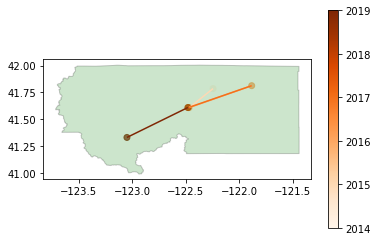

In [79]:
fig, ax = plt.subplots()

gdf_lines.plot(ax=ax, column=gdf_lines.index.values, cmap="Oranges", legend=True)

gdf_centroids.plot(ax=ax, cmap="Oranges", alpha=0.7)

#gdf_polys.plot(ax=ax, cmap="Oranges", edgecolor="black", alpha=0.2)

siskiyou.plot(ax=ax, color='green', alpha=0.2, edgecolor="black")

plt.show()

In [63]:
gdf

,inferred_average_ppet,droughted_area,geometry,centroid,linear_trend
year,,,,,
2014,78.218,3.130650e+10,"POLYGON ((-122.29643 41.04165, -122.77212 41.2...",POINT (-122.24498 41.78556),None
2015,43.258,4.414500e+10,"POLYGON ((-122.93127 40.50225, -123.75838 41.4...",POINT (-122.46628 41.60833),LINESTRING (-122.2449806197672 41.785562740080...
2016,92.593,1.782000e+10,"POLYGON ((-121.68038 41.07837, -122.57489 41.6...",POINT (-121.88443 41.81277),LINESTRING (-122.466277494617 41.6083300772062...
2017,38.984,4.438800e+10,"POLYGON ((-122.93127 40.50225, -123.90867 41.6...",POINT (-122.47445 41.60839),LINESTRING (-121.8844313974428 41.812766802438...
2018,32.713,4.455000e+10,"POLYGON ((-122.93127 40.50225, -124.00960 41.7...",POINT (-122.48038 41.60878),LINESTRING (-122.4744452809016 41.608387321823...
2019,NaN,1.883250e+10,"POLYGON ((-122.93127 40.50225, -124.00960 41.7...",POINT (-123.04886 41.32949),LINESTRING (-122.4803775819461 41.608775203590...


In [ ]:
raise ValueError("Testing cells below")

In [49]:
# Exporting siskiyou for later use
# Have to drop columns

# Copy gdf
gdf_out = gdf.copy()

# Weird columns to drop
drop_columns = ['centroid', 'linear_trend']

# Drop columns
gdf_out = gdf_out.drop(columns=drop_columns, inplace=True)

# Create out path
#gdf_out_path = os.path.join(home, "Desktop", "drought-tracker", "data", "created", "siskiyou_tracked.geojson")

# Export
#gdf_out.to_file(gdf_out_path, driver="GeoJSON")

In [ ]:
fig, ax = plt.subplots()

ax.set(title="Cumulative P/PET values, Summer 2019\nSiskiyou County, OR")

year_binary_grid.plot(column='ppet', cmap='viridis_r', ax=ax, legend=True)

josephine.plot(ax=ax, color='none', edgecolor='black')

In [ ]:
# Create grid polygon
grid = create_awhere_grid(aoi=josephine,
                          out_crs='4236',
                          calc_crs='2019')

# Add centroid column
grid['centroid'] = grid.geometry.apply(lambda poly: poly.centroid)

# Check to see if everything looks correct
fig, ax = plt.subplots()
grid.plot(color="none", linewidth=1, edgecolor='orange', ax=ax, zorder=3)
josephine.plot(color='green', zorder=2, ax=ax)

plt.show()

In [ ]:
ppet_grid_df = get_ppet(ppet_grid_df=grid,
                        start_date="2020-04-01",
                        end_date="2020-04-30",
                        drop_null=False,
                        testing=False)

In [ ]:
binary_grid = binary_threshold(gdf=ppet_grid_df,
                               daily_acc_ppet_threshold=0.2,
                               month=4,
                               year=2020)

binary_grid[binary_grid.meet_thresh==1].count()

In [ ]:
hull = to_convex_hull(binary_grid, 4326)

In [ ]:
fig, ax = plt.subplots()

hull.plot(ax=ax, color='none', edgecolor='red', zorder=4)
binary_grid.plot(column='ppet', cmap='coolwarm_r', ax=ax, alpha=0.6, zorder=3)
josephine.plot(color='green', alpha=0.9, ax=ax)

plt.show()